In [ ]:
%pip install scikit-learn
%pip install plotly

In [3]:
from sklearn.manifold import TSNE
import numpy as np
from db import DB
from models import CourseWrapper
import json

with DB('./gen.db') as db:
    rows = db.execute('''SELECT * FROM CourseWrappers''')

course_wrappers = [CourseWrapper(*tup[1:]) for tup in rows]
embeddings = np.array([json.loads(tup[-1]) for tup in rows])


In [4]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3, early_exaggeration=30)
embeddings_2d = tsne.fit_transform(embeddings)

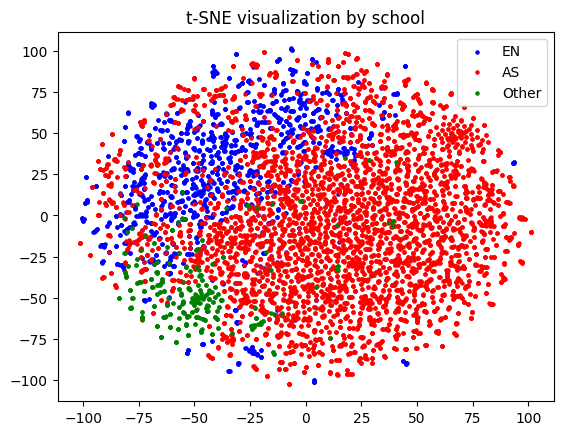

In [6]:
import matplotlib.pyplot as plt

stc = {'EN': [], 'AS': [], 'Other': []}
for i, course in enumerate(course_wrappers):
    if course.school in stc: stc[course.school].append(embeddings_2d[i])
    else: stc['Other'].append(embeddings_2d[i])

en_embds = np.array(stc['EN'])
as_embds = np.array(stc['AS'])
ot_embds = np.array(stc['Other'])

plt.scatter(en_embds[:, 0], en_embds[:, 1], color='blue', label='EN', s=5)
plt.scatter(as_embds[:, 0], as_embds[:, 1], color='red', label='AS', s=5)
plt.scatter(ot_embds[:, 0], ot_embds[:, 1], color='green', label='Other', s=5)

plt.title('t-SNE visualization by school')
plt.legend()
plt.show()

In [7]:
# i'd like to thank leetcode for this one

def deps_from_string(s: str):
    deps = []

    def is_breakpoint(i: int) -> bool:
        things = {'EN', 'AS', 'ME', 'MI'}
        return s[i:i+2] in things

    l, r = 0, 0
    while l < len(s):
        if is_breakpoint(l):
            r = l+1
            while r < len(s) and not is_breakpoint(r): r += 1
            if r == len(s): deps.append(s[l:r])
            else: deps.append(s[l:r-2])
            l = r
        
        else: l += 1

    assert l == r == len(s)
    return deps

dep_to_course = {}
dep_to_embd = {}
for i, course in enumerate(course_wrappers):
    deps = deps_from_string(course.departments)
    for d in deps:
        if d not in dep_to_course: 
            dep_to_course[d] = []
            dep_to_embd[d] = []
        dep_to_course[d].append(course)
        dep_to_embd[d].append(embeddings_2d[i])

In [ ]:
%pip install mplcursors

In [14]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import mplcursors

fig, ax = plt.subplots(figsize=(10, 6))

scatter_plots = []
for department in dep_to_embd:
    points = dep_to_embd[department]
    x_points = [p[0] for p in points]
    y_points = [p[1] for p in points]

    scatter =  ax.scatter(x_points, y_points, label=department, s=1)
    scatter_plots.append(scatter)

    center_x = sum(x_points) / len(x_points)
    center_y = sum(y_points) / len(y_points)

    r = max(max([abs(p[0] - center_x), abs(p[1] - center_y)]) for p in points)
    circle = Circle((center_x, center_y), radius=r, facecolor='none')
    ax.add_patch(circle)

# ax.autoscale(enable=True)
# ax.set_aspect('equal', 'box')
# ax.margins(0.1, 0.1)
# ax.set_xlim(auto=True)
# ax.set_ylim(auto=True)

cursor = mplcursors.cursor(scatter_plots, hover=True)

plt.title('t-SNE visualization by department')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>